In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from keras_cv import layers as kcv_layers
import cv2

In [2]:
# tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [3]:
class GaussianKernel(tf.keras.initializers.Initializer):

    def _pre_computed(self):
        return np.array([[0.01582423, 0.01649751, 0.01672824, 0.01649751, 0.01582423],
       [0.01649751, 0.01719942, 0.01743997, 0.01719942, 0.01649751],
       [0.01672824, 0.01743997, 0.01768388, 0.01743997, 0.01672824],
       [0.01649751, 0.01719942, 0.01743997, 0.01719942, 0.01649751],
       [0.01582423, 0.01649751, 0.01672824, 0.01649751, 0.01582423]])

    def __init__(self, shape, sigma=1, in_channels=None):
        self.in_channels = in_channels
        self.sigma = sigma
        self.shape = shape

    def __call__(self, shape, dtype=None):
        kernel_weights = self._pre_computed()
        if self.in_channels is not None:
            kernel_weights = np.expand_dims(kernel_weights, axis=-1)
            kernel_weights = np.repeat(kernel_weights, self.in_channels, axis=-1)
            kernel_weights = np.expand_dims(kernel_weights, axis=-1)
        return tf.constant(kernel_weights, dtype)

In [4]:
gaussian = layers.Conv2D(filters=1,kernel_size=(5,5), use_bias=False, padding='same',
                        kernel_initializer=GaussianKernel(shape=(5,5), in_channels=3, sigma=3), name="gaussian")

In [5]:
class LaplacianKernel(tf.keras.initializers.Initializer):
    def __init__(self, in_channels=1):
        self.kernel = np.array([

                [-1,-1,-1,-1,-1],
                [-1,-1,-1,-1,-1],
                [-1,-1,24.3,-1,-1],
                [-1,-1,-1,-1,-1],
                [-1,-1,-1,-1,-1],

        ])
        self.in_channels = in_channels

    def __call__(self, shape, dtype=None):
        kernel_weights = self.kernel
        if self.in_channels is not None:
            kernel_weights = np.expand_dims(kernel_weights, axis=-1)
            kernel_weights = np.repeat(kernel_weights, self.in_channels, axis=-1)
            kernel_weights = np.expand_dims(kernel_weights, axis=-1)
        return tf.constant(kernel_weights, dtype)

In [6]:
laplacian = layers.Conv2D(filters=1, kernel_size=5, use_bias=False, padding='same',
                        kernel_initializer=LaplacianKernel(in_channels=1), name="laplacian")

In [7]:
class ThresholdLayer(layers.Layer):
    def __init__(self, thresh=None, **kwargs):
        super(ThresholdLayer, self).__init__(**kwargs)
        self.thresh = thresh

    def _threshold(self, a, thresh=None):
        mean = tf.numpy_function(np.mean, [a], a.dtype)
        if thresh is not None:
            mean = mean * thresh
        return tf.where(tf.less(a, tf.zeros_like(a) + mean), tf.zeros_like(a), tf.ones_like(a))

    def __call__(self, inputs):
        return self._threshold(inputs, self.thresh)

In [8]:
threshold = ThresholdLayer(thresh=0.02, name="threshold")

In [9]:
frame = cv2.imread('examples/parrot.jpg')

In [10]:
frame = cv2.resize(frame, (640, 480))
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

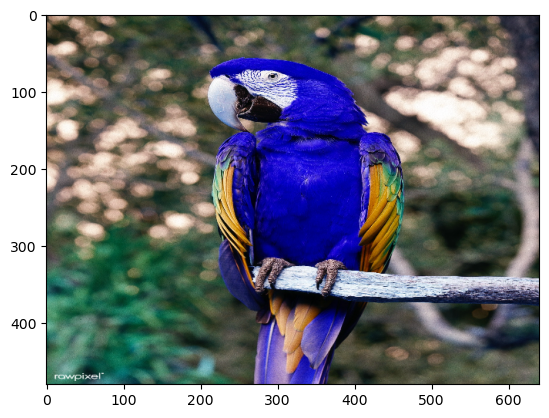

In [11]:
plt.imshow(frame)

In [12]:
model = tf.keras.Sequential()
model.add(keras.Input(type_spec=tf.TensorSpec((1, 480, 640, 3))))
model.add(gaussian)
model.add(layers.Rescaling(scale=1./255))
model.add(laplacian)
model.add(threshold)
model.compile()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-01-02 19:57:42.650953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-02 19:57:42.651088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
frame = np.array([frame])

In [14]:
frame = model.predict(frame)

2024-01-02 19:57:42.895110: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-02 19:57:42.931690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 642ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x480x640x1xi1>'


In [15]:
frame.shape

(1, 480, 640, 1)

In [16]:
frame.dtype

dtype('float32')

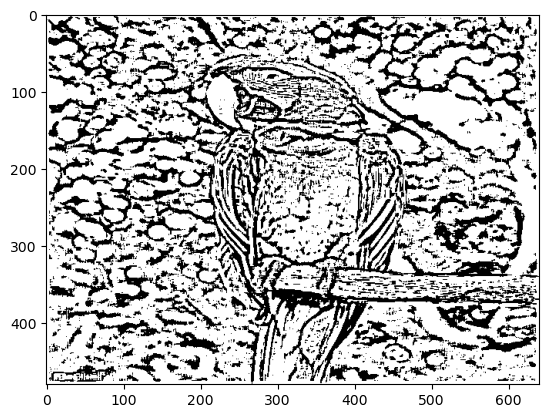

In [17]:
plt.imshow(frame[0,:,:,:], cmap='gray')

In [18]:
vid = cv2.VideoCapture(1)
frame_count = 0
while(True):
    frame_count += 1
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    frame = cv2.resize(frame, (640, 480))
    frame = cv2.flip(frame, 1)

    #the model wants a numpy array of images, we just wrap ours in one
    frame = np.array([frame])

    frame = model.predict(frame)

    #the model spits out a numpy array of images, we just strip it

    frame = frame[0,:,:,:]

    # Display the resulting frame
    cv2.imshow('frame', frame)

    key = cv2.waitKey(1) & 0xFF
    # if the q key was pressed, break from the loop

    if key == ord("q"):
        break

vid.release()
cv2.destroyAllWindows()

OpenCV: not authorized to capture video (status 0), requesting...
OpenCV: camera failed to properly initialize!


error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
